# MODELO: NEURAL NETWORK LSTM

In [ ]:
import pandas as pd
import numpy as np
import glob
import warnings
import logging
import matplotlib.pyplot as plt

# Desactiva los warnings y ajusta el logging
warnings.filterwarnings("ignore")
logging.getLogger("NP").setLevel(logging.ERROR)

In [2]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error
from sklearn.preprocessing import MinMaxScaler

2024-11-22 08:09:45.765175: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1732259385.781779 2978167 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1732259385.786876 2978167 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-22 08:09:45.804527: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


#### 1. Cargamos los datos de entrenamiento

In [3]:
# Get a list of all CSV files in the directory
csv_files = glob.glob('predictions_dia_avg/predictions_0.csv/*.csv')

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    df_temp = pd.read_csv(file)
    dfs.append(df_temp)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Optional: Reset the index of the final DataFrame
df.reset_index(drop=True, inplace=True)

df.head()


df = df.rename(columns={'day': 'ds', 'avg_all_users': 'y'})

# Asumiendo que tu DataFrame se llama 'df'

# Primero, asegúrate de que 'ds' es de tipo datetime
df['ds'] = pd.to_datetime(df['ds'])

# Luego, elimina la información de zona horaria
df['ds'] = df['ds'].dt.tz_localize(None)

# Verifica el tipo de datos de la columna 'ds'
print(df['ds'].dtype)

df.head()

datetime64[ns]


,ds,y
0,2019-09-30,0.031848
1,2019-10-01,0.037974
2,2019-10-02,0.039463
3,2019-10-03,0.039074
4,2019-10-04,0.042678


In [4]:
df['ds'] = pd.to_datetime(df['ds'])

df_data_train = df[df["ds"] < "2023-12-01 00:00:00"]
df_data_test = df[df["ds"] >= "2023-12-01 00:00:00"] 

# Los datos de test contienen diciembre, enero, febrero, marzo y 15 días de abril

#### 2. Preparación de los datos para el modelo LSTM

Es necesario dividir los datos en secuencias, según el tamaño de las ventanas que consideremos, en este caso 90 días de entrada (tres meses) y 30 de salida (un mes)

In [27]:
data = df_data_train

# Escalado de datos
scaler = MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data[['y']])
data['y_scaled'] = data_scaled

# Función para crear ventanas deslizantes (sliding windows)
def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps - output_steps + 1):
        X.append(data[i:i + input_steps])
        y.append(data[i + input_steps:i + input_steps + output_steps])
    return np.array(X), np.array(y)

# Configuración de ventanas
input_steps = 90  # 3 meses
output_steps = 30  # 1 mes

# Creación de secuencias
X, y = create_sequences(data_scaled, input_steps, output_steps)

# División en conjunto de entrenamiento y prueba
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

In [6]:
data

,ds,y,y_scaled
0,2019-09-30,0.031848,0.516211
1,2019-10-01,0.037974,0.657884
2,2019-10-02,0.039463,0.692318
3,2019-10-03,0.039074,0.683328
4,2019-10-04,0.042678,0.766672
...,...,...,...
1518,2023-11-26,0.013365,0.088727
1519,2023-11-27,0.013755,0.097729
1520,2023-11-28,0.013509,0.092039
1521,2023-11-29,0.013668,0.095726


#### 3. Entrenamiento de un modelo básico

In [7]:
# Construcción del modelo LSTM
model = Sequential([
    LSTM(64, activation='relu', input_shape=(input_steps, 1), return_sequences=False),
    Dense(output_steps)  # Salida de 30 días
])

# Compilación del modelo
model.compile(optimizer='adam', loss='mse')

# Entrenamiento del modelo
history = model.fit(
    X_train, y_train.squeeze(),  # y_train necesita eliminar dimensión extra (30, 1 -> 30)
    validation_data=(X_test, y_test.squeeze()),
    epochs=20,
    batch_size=32,
    verbose=1
)

Epoch 1/20


2024-11-22 08:09:47.716296: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0031 - val_loss: 4.2529e-04
Epoch 2/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.7625e-04 - val_loss: 3.8689e-04
Epoch 3/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.1779e-04 - val_loss: 3.7493e-04
Epoch 4/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.2511e-04 - val_loss: 3.5254e-04
Epoch 5/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.7525e-04 - val_loss: 2.4499e-04
Epoch 6/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.7350e-04 - val_loss: 3.1512e-04
Epoch 7/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.6802e-04 - val_loss: 2.6848e-04
Epoch 8/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.7077e-04 - val_loss: 2.4986e-04
Epoch 9/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 2.5381e-04 - val_loss: 2.7188e-04
Epoch 10/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.9658e-04 - val_loss: 1.8036e-04
Epoch 11/20
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 2.7435e-04 - val_loss: 2

##### 3.1 Evaluación

In [8]:
# Predicciones en el conjunto de prueba
y_pred = model.predict(X_test)

# Inversión del escalado para las métricas
y_test_inverse = scaler.inverse_transform(y_test.squeeze())
y_pred_inverse = scaler.inverse_transform(y_pred)

# Cálculo de métricas de error
mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
mape = np.mean(np.abs((y_test_inverse - y_pred_inverse) / y_test_inverse)) * 100

# Resultados
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAPE: {mape:.2f}%")

9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
MAE: 0.0005
RMSE: 0.0006
MAPE: 3.67%


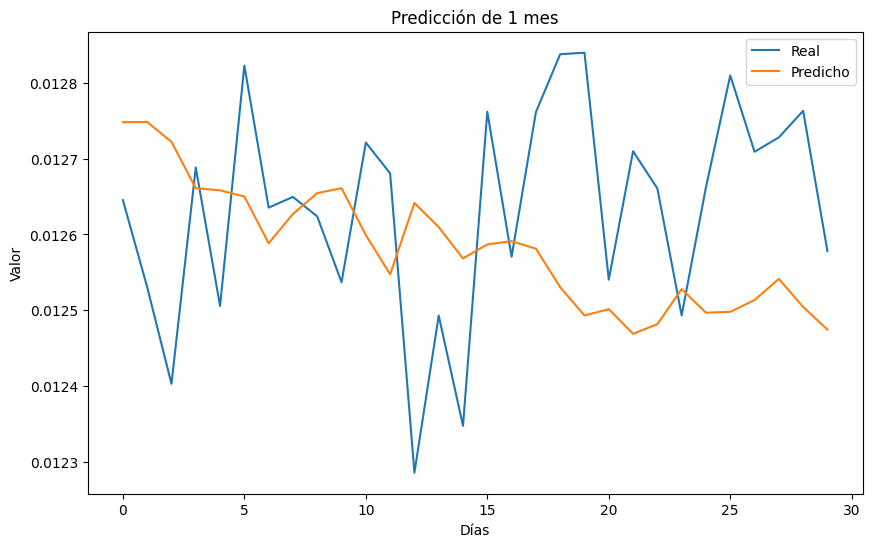

In [9]:
# Graficar resultados (opcional)
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(y_test_inverse[0], label="Real")
plt.plot(y_pred_inverse[0], label="Predicho")
plt.title("Predicción de 1 mes")
plt.xlabel("Días")
plt.ylabel("Valor")
plt.legend()
plt.show()


#### 4. CrossValidation

Dividimos los datos en 5 folds y realizamos un entrenamiento mediante crossvalidation para comparar evaluaciones

In [10]:
from sklearn.model_selection import TimeSeriesSplit
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Configuración de TimeSeriesSplit
n_splits = 5
tscv = TimeSeriesSplit(n_splits=n_splits)

# Listas para almacenar métricas
mae_list, rmse_list, mape_list = [], [], []

# Validación cruzada
for fold, (train_index, test_index) in enumerate(tscv.split(X)):
    print(f"Fold {fold + 1}/{n_splits}")
    
    # Dividir datos en entrenamiento y prueba
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
    # Construcción del modelo LSTM
    model = Sequential([
        LSTM(64, activation='tanh', input_shape=(input_steps, 1), return_sequences=False),
        Dense(output_steps)
    ])
    model.compile(optimizer='adam', loss='mse')
    
    # Entrenamiento del modelo
    model.fit(X_train, y_train.squeeze(), epochs=10, batch_size=32, verbose=0)
    
    # Predicción
    y_pred = model.predict(X_test)
    
    # Inversión del escalado
    y_test_inverse = scaler.inverse_transform(y_test.squeeze())
    y_pred_inverse = scaler.inverse_transform(y_pred)
    
    # Cálculo de métricas
    mae = mean_absolute_error(y_test_inverse, y_pred_inverse)
    rmse = np.sqrt(mean_squared_error(y_test_inverse, y_pred_inverse))
    mape = np.mean(np.abs((y_test_inverse - y_pred_inverse) / y_test_inverse)) * 100
    
    # Almacenar métricas
    mae_list.append(mae)
    rmse_list.append(rmse)
    mape_list.append(mape)
    
    print(f"Fold {fold + 1} - MAE: {mae:.4f}, RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

# Promediar métricas
print("\n--- Resultados Promediados ---")
print(f"MAE Promedio: {np.mean(mae_list):.4f}")
print(f"RMSE Promedio: {np.mean(rmse_list):.4f}")
print(f"MAPE Promedio: {np.mean(mape_list):.2f}%")


Fold 1/5


8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Fold 1 - MAE: 0.0006, RMSE: 0.0007, MAPE: 4.39%
Fold 2/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fold 2 - MAE: 0.0005, RMSE: 0.0007, MAPE: 4.48%
Fold 3/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Fold 3 - MAE: 0.0004, RMSE: 0.0006, MAPE: 3.53%
Fold 4/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fold 4 - MAE: 0.0004, RMSE: 0.0005, MAPE: 3.46%
Fold 5/5
8/8 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Fold 5 - MAE: 0.0009, RMSE: 0.0010, MAPE: 6.74%

--- Resultados Promediados ---
MAE Promedio: 0.0006
RMSE Promedio: 0.0007
MAPE Promedio: 4.52%


Entrenamos un modelo con TODOS los datos

In [11]:
# Entrenamiento final con todos los datos de entrenamiento
model_final = Sequential([
    LSTM(64, activation='tanh', input_shape=(input_steps, 1), return_sequences=False),
    Dense(output_steps)
])
model_final.compile(optimizer='adam', loss='mse')

# Entrenar el modelo final con los datos de entrenamiento completos
model_final.fit(
    X, y.squeeze(),
    validation_split=0.2,  # Validación durante el entrenamiento para verificar sobreajuste
    epochs=50,             # Incrementamos los epochs para capturar patrones más complejos
    batch_size=32,
    verbose=1
)

Epoch 1/50


36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - loss: 0.0024 - val_loss: 3.3001e-04
Epoch 2/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.2857e-04 - val_loss: 4.3645e-04
Epoch 3/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.7174e-04 - val_loss: 5.0342e-04
Epoch 4/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.9734e-04 - val_loss: 4.7941e-04
Epoch 5/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.3653e-04 - val_loss: 3.6661e-04
Epoch 6/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 3.7951e-04 - val_loss: 3.8172e-04
Epoch 7/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.8472e-04 - val_loss: 4.3667e-04
Epoch 8/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.8875e-04 - val_loss: 4.2307e-04
Epoch 9/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - loss: 4.2902e-04 - val_loss: 4.9331e-04
Epoch 10/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.9729e-04 - val_loss: 4.7271e-04
Epoch 11/50
36/36 ━━━━━━━━━━━━━━━━━━━━ 1s 28ms/step - loss: 3.6589e-04 - val_loss: 3

#### 5. Testing con usuarios concretos

In [12]:
# Get a list of all CSV files in the directory
csv_files = glob.glob('data_testing/cluster_0_filter_users.csv/*.csv')

# Initialize an empty list to store individual DataFrames
dfs = []

# Loop through each CSV file and read it into a DataFrame
for file in csv_files:
    df_temp = pd.read_csv(file)
    dfs.append(df_temp)

# Concatenate all DataFrames into a single DataFrame
df = pd.concat(dfs, ignore_index=True)

# Optional: Reset the index of the final DataFrame
df.reset_index(drop=True, inplace=True)

df_users = df.rename(columns={'day': 'ds', 'avg_value': 'y'})

# Asumiendo que tu DataFrame se llama 'df'

# Primero, asegúrate de que 'ds' es de tipo datetime
df_users['ds'] = pd.to_datetime(df_users['ds'])

# Luego, elimina la información de zona horaria
df_users['ds'] = df_users['ds'].dt.tz_localize(None)

# Verifica el tipo de datos de la columna 'ds'
print(df_users['ds'].dtype)

df_users.head()

datetime64[ns]


,ds,serial_number,y
0,2021-09-08,J18YA009425,0.000167
1,2021-09-08,J18YA009432,0.006708
2,2021-09-08,J18YA009438,0.001708
3,2021-09-08,J18YA009463,0.021708
4,2021-09-08,J18YA009467,0.013609


In [13]:
df_data_train_mid = df_users[df_users["ds"] < "2024-01-01 00:00:00"]
df_data_test_final = df_users[df_users["ds"] >= "2024-01-01 00:00:00"] 

df_data_train_user = df_data_train_mid[df_data_train_mid["ds"] < "2023-12-01 00:00:00"]
df_data_test_user = df_data_train_mid[df_data_train_mid["ds"] >= "2023-12-01 00:00:00"] # Mes de diciembre 2023

In [21]:
# Filtrar por serial_number de interés
serial_to_predict = "J18YA009425"  # Serial que quieres predecir
df_filtered = df_data_test_user[df_data_test_user['serial_number'] == serial_to_predict]

In [22]:
len(df_filtered['y'])

31

In [24]:
def create_sequences(data, input_steps, output_steps):
    X, y = [], []
    for i in range(len(data) - input_steps):
        # Obtención de la secuencia de entrada
        X_seq = data[i:i + input_steps]
        
        # Obtención de la secuencia de salida, con relleno de ceros si es necesario
        y_seq = data[i + input_steps:i + input_steps + output_steps]
        
        # Rellenar con ceros si no hay suficientes datos en la secuencia de salida
        if len(y_seq) < output_steps:
            y_seq = np.pad(y_seq, (0, output_steps - len(y_seq)), mode='constant', constant_values=0)
        
        X.append(X_seq)
        y.append(y_seq)
    
    return np.array(X), np.array(y)

# Configuración de las ventanas
input_steps = 7  # Por ejemplo, 90 días de entrada
output_steps = 30  # Por ejemplo, 30 días de salida

# Usamos solo la columna 'y' para las predicciones
X_test, y_test = create_sequences(df_filtered['y'].values, input_steps, output_steps)

print(f"X_test: {X_test.shape}, y_test: {y_test.shape}")


X_test: (24, 7), y_test: (24, 30)


In [25]:
# Supongamos que el modelo ya está entrenado
# Realizamos las predicciones con el modelo LSTM
y_pred = model_final.predict(X_test)

# Desescalar las predicciones y los valores reales
y_test_unscaled = scaler.inverse_transform(y_test)  # Desescalar los valores reales
y_pred_unscaled = scaler.inverse_transform(y_pred)  # Desescalar las predicciones

# Calcular métricas de evaluación
mae = mean_absolute_error(y_test_unscaled, y_pred_unscaled)
rmse = np.sqrt(mean_squared_error(y_test_unscaled, y_pred_unscaled))
mape = mean_absolute_percentage_error(y_test_unscaled, y_pred_unscaled) * 100

# Imprimir métricas
print(f"Conjunto de Prueba - MAE: {mae:.4f}")
print(f"Conjunto de Prueba - RMSE: {rmse:.4f}")
print(f"Conjunto de Prueba - MAPE: {mape:.2f}%")



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step
Conjunto de Prueba - MAE: 0.0013
Conjunto de Prueba - RMSE: 0.0014
Conjunto de Prueba - MAPE: 13.89%


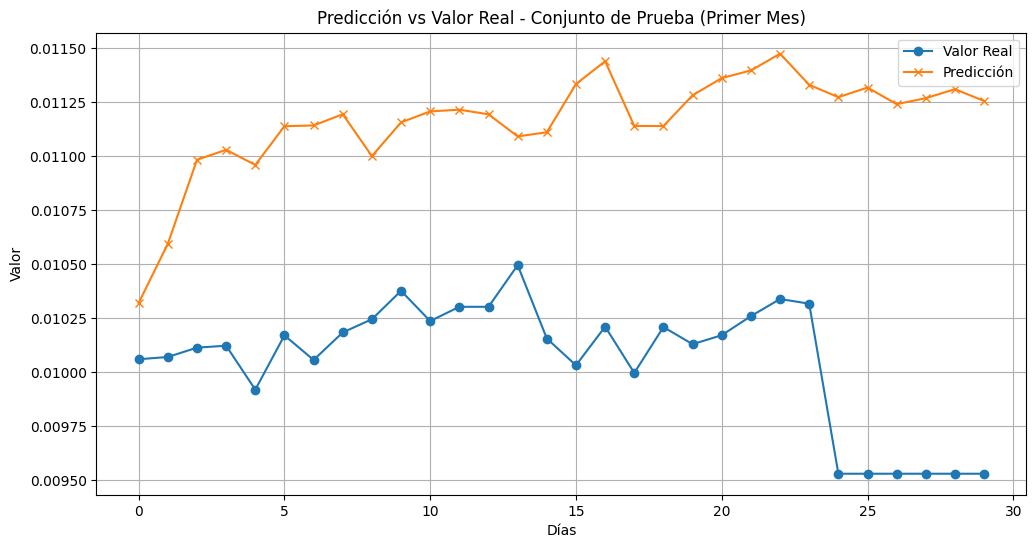

In [26]:
# Graficar los resultados
import matplotlib.pyplot as plt

# Graficar las predicciones y los valores reales del primer segmento del conjunto de prueba
plt.figure(figsize=(12, 6))
plt.plot(y_test_unscaled[0], label="Valor Real", marker='o')
plt.plot(y_pred_unscaled[0], label="Predicción", marker='x')
plt.title("Predicción vs Valor Real - Conjunto de Prueba (Primer Mes)")
plt.xlabel("Días")
plt.ylabel("Valor")
plt.legend()
plt.grid()
plt.show()